In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import copy
from scipy import stats
import statistics
import math
from scipy.stats import shapiro, kstest, normaltest
import statsmodels.api as sm
#import statsmodels

In [2]:
INFINITY = 1000000

PASSWORD = "bridport20"
Z_THRESHOLD = 2

ALPHA = 0.05

# for weight calculation (influence of multiple tests)
TESTS_WEIGHT = 0.8
STD_WEIGHT = 10

In [3]:
class EntryDivider:
    """
    Separates and cleans each entry from person's dataset
    """
    
    def __init__(self, df):
        self.df = df
        self.nr_entries = self.df["entry"].max() + 1
        self.entries = self.divide_entries()
        
    def divide_entries(self):
        """
        Separates each entry from person's dataset
        """
        entries = []
        for entry_i in range(self.nr_entries):
            curr_entry = self.df[self.df["entry"] == entry_i]
            curr_entry = self._reset_time(curr_entry.sort_values(by = ["time"]).reset_index(drop = True))
            curr_entry, is_still_clean = self._remove_faulty(curr_entry)
            if (is_still_clean and self._is_correct(curr_entry)):
                entries.append(curr_entry)
            else:
                pass #print("not clean data, entry = ", entry_i)
            
        return entries
    
    def _reset_time(self, entry):
        """
        Resets times of the entry to their relative times
        """
        start_time = entry["time"].min()
        entry["time"] -= start_time
        
        return entry
    
    def _remove_faulty(self, entry):
        """
        Checks if entry doesnt have any other pressed keys
        """
        clean_entry = copy.deepcopy(entry)
        
        for key_char in list(clean_entry["key_char"]):
            if (not key_char in PASSWORD):
                return clean_entry, False
        return clean_entry, True
    
    def _is_correct(self, entry):
        """
        Checks if entry corresponds to password
        """
        clean_entry = entry[entry["event"] == "KeyPress"]
        clean_entry = clean_entry.sort_values(by = ["time"]).reset_index(drop = True)
        entered_text = "".join(list(clean_entry["key_char"]))
        return entered_text == PASSWORD
    
    

In [4]:
class Event_OutlierHandler_Transformer:
    """
    Detects and removes outliers from a specific person
    """
    
    def __init__(self, entries): #[DataFrame]
        self.original_entries = entries
        self.clean_entries = self.handle_event_outliers_and_transform()

    
    def handle_event_outliers_and_transform(self):
        """
        Removes outliers from entries
        """
        entries = copy.deepcopy(self.original_entries)
        keypress_times, keyrelease_times = self._get_events_dicts()
        
        z_keypress_times = self._get_z_scores(keypress_times)
        z_keyrelease_times = self._get_z_scores(keyrelease_times)
        
        for entry_i in range(len(entries)):
            entries[entry_i] = entries[entry_i].sort_values(by = ["key_char", "time"]).reset_index(drop = True)
            
            for event_i in range(0, len(entries[entry_i])-1, 2):
                curr_key_char = entries[entry_i].iloc[event_i]["key_char"]
                key = self._key_index((event_i+1)//2, curr_key_char)
                
                if (abs(z_keypress_times[key][entry_i]) > Z_THRESHOLD):
                    entries[entry_i].loc[event_i, "time"] = statistics.mean(keypress_times[key])
                if (abs(z_keyrelease_times[key][entry_i]) > Z_THRESHOLD):
                    entries[entry_i].loc[event_i+1, "time"] = statistics.mean(keyrelease_times[key])
                
                # uncomment if you want to transform -> will create additional tasks
                entries[entry_i].loc[event_i, "time"] = self._transform(entries[entry_i].loc[event_i, "time"])
                entries[entry_i].loc[event_i+1, "time"] = self._transform(entries[entry_i].loc[event_i+1, "time"])
                
        return entries  
    
    def _transform(self, time):
        return math.log(time + 0.01)
        
        
    def _get_events_dicts(self):
        """
        Constructs dicts of press and release times for events
        """
        entries = copy.deepcopy(self.original_entries)
        keypress_times = {}
        keyrelease_times = {}
        
        sorted_password = ''.join(sorted(PASSWORD))
        for i in range(len(PASSWORD)):
            key = self._key_index(i, sorted_password[i])
            keypress_times[key] = []
            keyrelease_times[key] = []
        
        for entry_i in range(len(entries)):
            curr_entry = entries[entry_i].sort_values(by = ["key_char", "time"]).reset_index(drop = True)
            
            if (len(entries[entry_i]) % 2 != 0):
                print("we've got uneven pressing/releasing for some reason \n")
                return
            
            for event_i in range(0, len(entries[entry_i])-1, 2):
                curr_key_char = curr_entry.iloc[event_i]["key_char"]
                key = self._key_index((event_i+1)//2, curr_key_char)

                keypress_times[key] += [curr_entry.iloc[event_i]["time"]]
                keyrelease_times[key] += [curr_entry.iloc[event_i+1]["time"]]
        
        return keypress_times, keyrelease_times
    
    
    def _key_index(self, index, char):
        return str(index) + ": " + char
    
    
    def _get_z_scores(self, arr_dict):
        """
        Calculates z-scores for arrays in dict with array keys
        """
        z_dict = {}
        for key, arr in arr_dict.items():
            
            if (statistics.mean(arr) == 0):
                z_dict[key] = copy.deepcopy(arr)
            else:
                z_dict[key] = stats.zscore(arr)
            
        return z_dict  

In [5]:
class Feature_OutlierHandler_Transformer:
    
    def __init__(self, feature_arr):
        self.original_arr = feature_arr
        self.clean_arr = self.handle_ouliers()
        
    def handle_ouliers(self):
        arr = copy.deepcopy(self.original_arr)
        outlier_indices = self._get_outlier_indices(arr)

        for i in outlier_indices:
            arr[i] = statistics.mean(arr)
            
        return arr
        
    def _get_outlier_indices(self, arr):
        z_scores_arr = stats.zscore(arr)  
        return [i for i in range(len(arr)) if (abs(z_scores_arr[i]) > Z_THRESHOLD)]
    

In [6]:
class Entry:
    """
    Provides information about each entry (its data and whether it's owner's)
    """
    
    def __init__(self, name, entry):
        self.is_owner = name == OWNER_NAME
        self.data = entry

In [7]:
class EntriesData:
    """
    Holds all the entry datas together
    """
    
    def __init__(self, entries: [Entry]):
        self.entries = entries
        
        
    def overview_plot_event_times(self, event):
        """
        Plots an event of each key of each key of entry of each individual
        """
        fig, ax = plt.subplots(figsize = (15, 15))
        xval = 0
        temp_entries = self.entries
        
        for key_char in PASSWORD:
            times = []
            for i in range(len(temp_entries)):
                entry = temp_entries[i].data
                time = entry[(entry["key_char"] == key_char) & (entry["event"] == event)]["time"].iloc[0]
                temp_entries[i].data = entry[entry["time"] != time]
                times.append(time)
                
            ax.scatter(np.linspace(xval, xval, len(times)), times)
            xval += 1
        
        ax.set_title("{}'s of each key of entry of each individual".format(event))
        locs, labels = plt.xticks() 
        plt.xticks(np.arange(len(PASSWORD)), [c for c in PASSWORD])
        
        
    def owner_event_distribution(self, event):
        """
        Plots density plot for the times of an event of each key
        """
        owner_entries = self._get_owner()
        
        fig, ax = plt.subplots(nrows = len(PASSWORD), figsize = (15, 6 * len(PASSWORD)))
        plt.subplots_adjust(hspace = 0.2)
        plt.suptitle("Distribution on owner's {}'s'".format(event))
        
        row = 0
        for key_char in PASSWORD:
            
            times = []
            for i in range(len(owner_entries)):
                entry = owner_entries[i].data
                time = entry[(entry["key_char"] == key_char) & (entry["event"] == event)]["time"].iloc[0]
                owner_entries[i].data = entry[entry["time"] != time]
                times.append(time)
                
            sns.distplot(times, ax = ax[row])
            ax[row].set_title(key_char, color = "red")
            row += 1
    
    
    def owner_presstime_distribution(self, fig, ax):
        """
        Plots density plot for the pressing times of each key
        """
        owner_entriesdata = self._get_owner()
        owner_entries = [owner_entry.data for owner_entry in owner_entriesdata]
        
        plt.subplots_adjust(hspace = 0.2)
        plt.suptitle("Distribution on owner's time of pressing each key")
        
        elapsed_times = {}
        sorted_password = ''.join(sorted(PASSWORD))
        for i in range(len(PASSWORD)):
            elapsed_times[self._key_index(i, sorted_password[i])] = [] 
        
        for entry_i in range(len(owner_entries)):
            curr_entry = owner_entries[entry_i].sort_values(by = ["key_char", "time"]).reset_index(drop = True)

            if (len(owner_entries[entry_i]) % 2 != 0):
                print("we've got uneven pressing/releasing for some reason \n")
                return
            
            for event_i in range(0, len(owner_entries[entry_i])-1, 2):
                elapsed_time = curr_entry.iloc[event_i+1]["time"] - curr_entry.iloc[event_i]["time"]
                curr_key_char = curr_entry.iloc[event_i]["key_char"]
                elapsed_times[self._key_index((event_i+1)//2, curr_key_char)] += [elapsed_time]
    
        return self._get_distribution(elapsed_times, fig, ax)
    
            
    def owner_between_keypress_distribution(self, fig, ax):
        """
        Plots density plot for the time between pressing 2 keys
        """
        owner_entriesdata = self._get_owner()
        keypress_entries = [owner_entry.data[owner_entry.data["event"] == "KeyPress"] for owner_entry in owner_entriesdata]
        
        plt.subplots_adjust(hspace = 0.2)
        plt.suptitle("Distribution on owner's time between pressing 2 keys")
        
        between_times = {}
        for i in range(len(PASSWORD)-1):
            between_times[self._key_index(i, PASSWORD[i] + "->" + PASSWORD[i+1])] = [] 
            
        for entry_i in range(len(keypress_entries)):
            curr_entry = keypress_entries[entry_i].sort_values(by = ["time"]).reset_index(drop = True)
            
            for event_i in range(len(curr_entry)-1):
                between_time = curr_entry.loc[event_i+1, "time"] - curr_entry.loc[event_i, "time"]
                curr_key_char1 = curr_entry.iloc[event_i]["key_char"]
                curr_key_char2 = curr_entry.iloc[event_i+1]["key_char"]
                try:
                    between_times[self._key_index(event_i, curr_key_char1 + "->" + curr_key_char2)] += [between_time]
                except:
                    pass # this one was an outlier that doesnt fit with the rest of the data
        
        return self._get_distribution(between_times, fig, ax)
    
    
    def _get_distribution(self, times_dict, fig, ax):
        try:
            c = COLOR
        except:
            c = "blue"
        
        normality = {}
        row = 0
        for key, times in times_dict.items():
            
            clean_times = Feature_OutlierHandler_Transformer(times).clean_arr

            normality[key] = [self._get_weight(clean_times), 
                              statistics.mean(clean_times), 
                              statistics.stdev(clean_times)]
            
            sns.distplot(clean_times, ax = ax[row], color = c, label = OWNER_NAME + " -> " + key)
            fig.legend()
            ax[row].set_title(key, color = "red")
            row += 1
        
        return normality     
            
            
    def _get_owner(self):
        copy_entries = copy.deepcopy(self.entries)
        return [entry for entry in copy_entries if (entry.is_owner)]
                
            
    def _key_index(self, index, char):
        return str(index) + ": " + char
    
    def _get_weight(self, arr):
        """
        Performs Shapiro-Wilk test and returns whether data is normally distributed
        """
        nr_passed = 0
        
        # Anderson-Darling test
        _, p = sm.stats.normal_ad(np.array(arr), axis = 0)
        nr_passed += 1 if (p > ALPHA) else 0
        
        # Shapiro-Wilk test
        _, p = shapiro(arr)
        nr_passed += 1 if (p > ALPHA) else 0
        
        # Kolmogorov-Smirnov test
        _, p = kstest(arr, "norm")
        nr_passed += 1 if (p > ALPHA) else 0
        
        # D’Agostino test
        _, p = normaltest(arr)
        nr_passed += 1 if (p > ALPHA) else 0
        
        # calculating our magic formula
        weight = 1 + (nr_passed - 1) * TESTS_WEIGHT if (nr_passed >= 1) else 0
        
        return weight       
    

In [8]:
names = []
names.append("Person1")
names.append("Person2")
names.append("Person3")
names.append("Person4")
names.append("Person5")

colors = ["chocolate", "blue", "red", "green", "yellow"]

def generate_entries():
    """
    Generating entries from all datasets
    """
    all_entries = []
    
    for name in names:
        name_entries = EntryDivider(pd.read_excel(name + ".xlsx", encoding = "utf8")).entries
        
        name_entries = Event_OutlierHandler_Transformer(name_entries).clean_entries
        
        for name_entry in name_entries:
            entry = Entry(name, name_entry)
            all_entries.append(entry)
            
    return all_entries

/Users/mariiaturchina/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/_adnorm.py:67: RuntimeWarning: divide by zero encountered in log
  S = np.sum((2*i[sl1]-1.0)/N*(np.log(z)+np.log(1-z[sl2])), axis=axis)


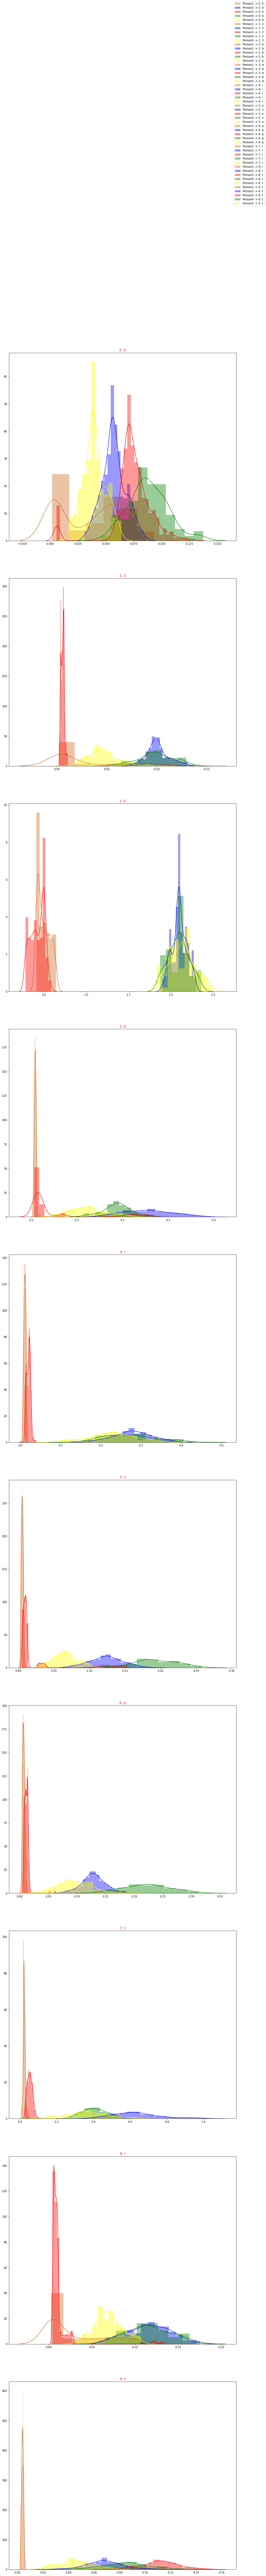

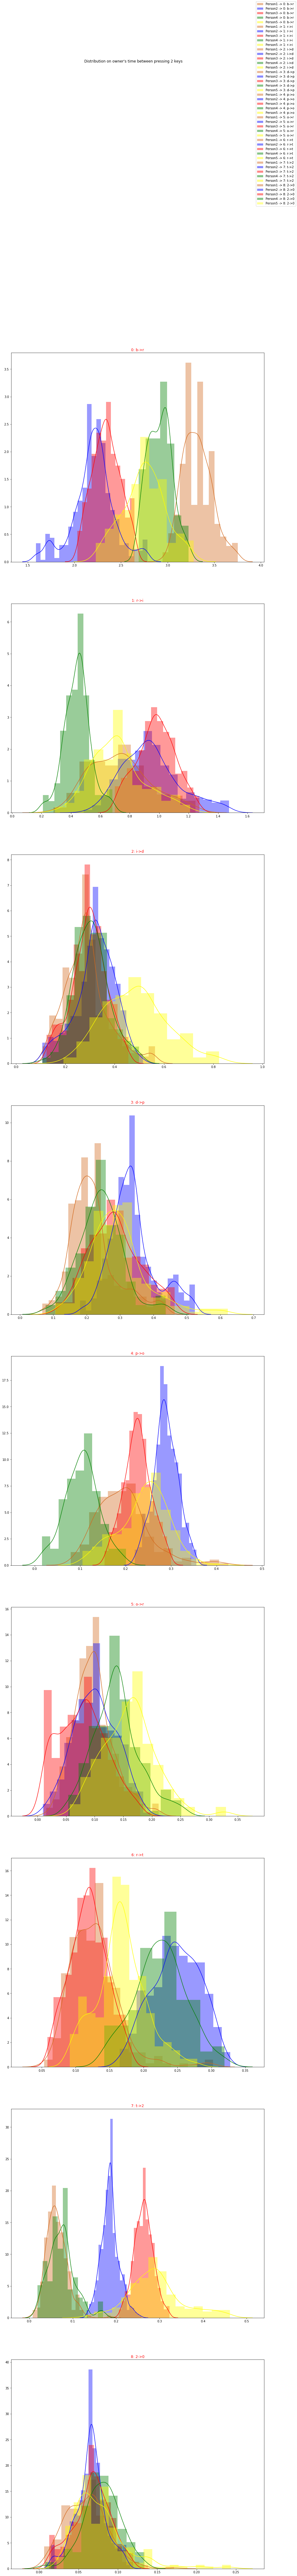

In [9]:
""" Generates graphs and statistics for for everybody """

i = 0
fig1, ax1 = plt.subplots(nrows = len(PASSWORD), figsize = (15, 15 * len(PASSWORD)))
fig2, ax2 = plt.subplots(nrows = len(PASSWORD)-1, figsize = (15, 15 * (len(PASSWORD)-1)))

distributions = {}
for name in names:
    OWNER_NAME = name
    COLOR = colors[i]
    i += 1
    
    distributions[name] = {}
    entries_data = EntriesData(generate_entries())
    
    distributions[name]["normality_presstime"] = entries_data.owner_presstime_distribution(fig1, ax1)
    
    distributions[name]["normality_between_keypress"] = entries_data.owner_between_keypress_distribution(fig2, ax2)
    
fig1.savefig("presstime_distribution.pdf")
fig2.savefig("between_keypress_distribution.pdf")


In [10]:
#entries_data.owner_event_distribution("KeyPress")

In [11]:
#entries_data.owner_event_distribution("KeyRelease")

In [12]:
distributions_df = pd.DataFrame.from_dict({(i, j): distributions[i][j]
                                           for i in distributions.keys()
                                           for j in distributions[i].keys()})

In [13]:
# adding influence of outliers in the score formula

features = ["normality_presstime", "normality_between_keypress"]

for name in names:
    
    min_std = INFINITY
    for feature in features:
        
        cleaned = copy.deepcopy(distributions_df[name][feature]).dropna()
        for i in range(len(cleaned)):
            curr_stdev = cleaned.iloc[i][2]
            min_std = curr_stdev if (curr_stdev < min_std) else min_std
            
    
    for feature in features:      
        for i in range(len(distributions_df[name][feature])):
            try:
                distributions_df[name][feature].iloc[i][0] += (STD_WEIGHT * min_std / distributions_df[name][feature].iloc[i][2])
            except:
                pass # its nan
              
distributions_df.to_csv("distributions.csv")


In [14]:
distributions_df

Person1  \
                                       normality_presstime   
0: 0     [0.26497025378184436, 0.03709598415747208, 0.0...   
1: 2     [0.19816578228417742, 0.029400893384925738, 0....   
2: b     [0.10460350447654956, 0.49629950409996504, 0.0...   
3: d     [4.674076083722984, 0.008473201252233886, 0.00...   
4: i     [2.9293581018731056, 0.011436639818883406, 0.0...   
5: o     [5.873826342581862, 0.005497497768529719, 0.00...   
6: p     [1.6182364818197352, 0.007445520184900491, 0.0...   
7: r     [1.3147634353337638, 0.02420642407872165, 0.00...   
8: r     [0.21401102201510028, 0.030704299680580388, 0....   
9: t     [11.8, 0.004086924585374158, 0.000759194208457...   
0: b->r                                                NaN   
1: r->i                                                NaN   
2: i->d                                                NaN   
3: d->p                                                NaN   
4: p->o                                                NaN   
5: o->r                                                NaN   
6: r->t                                                NaN   
7: t->2                                                NaN   
8: 2->0                                                NaN   

                                                            \
                                normality_between_keypress   
0: 0                                                   NaN   
1: 2                                                   NaN   
2: b                                                   NaN   
3: d                                                   NaN   
4: i                                                   NaN   
5: o                                                   NaN   
6: p                                                   NaN   
7: r                                                   NaN   
8: r                                                   NaN   
9: t                                                   NaN   
0: b->r  [0.04920324970808506, 3.3161388803427934, 0.15...   
1: r->i  [0.037171471864801284, 0.7359897859275988, 0.2...   
2: i->d  [0.0864248062500332, 0.2847342494942897, 0.087...   
3: d->p  [0.10792072811962532, 0.2203348183269566, 0.07...   
4: p->o  [0.12959827287852604, 0.19468091768492038, 0.0...   
5: o->r  [0.21932706049623596, 0.0980567126772149, 0.03...   
6: r->t  [0.20782165047994197, 0.1277288865733663, 0.03...   
7: t->2  [0.32671668349069655, 0.0632626996962968, 0.02...   
8: 2->0  [1.2869814045255565, 0.060016373064760466, 0.0...   

                                                   Person2  \
                                       normality_presstime   
0: 0     [11.0, 0.05712762082279361, 0.010630905898606952]   
1: 2     [9.463687385430951, 0.10105242265775138, 0.011...   
2: b     [1.217721717667416, 2.1031150578029925, 0.0873...   
3: d     [2.0078492755292094, 0.2562268854575381, 0.052...   
4: i     [4.083886101105839, 0.27939220754311617, 0.046...   
5: o     [7.196523556594245, 0.12370551455259754, 0.023...   
6: p     [7.898739502809461, 0.12930824094098917, 0.020...   
7: r     [0.8209455311939784, 0.6324699115239287, 0.129...   
8: r     [4.280467705723751, 0.11566438117340172, 0.024...   
9: t     [8.25616755795074, 0.06825678415718685, 0.0146...   
0: b->r                                                NaN   
1: r->i                                                NaN   
2: i->d                                                NaN   
3: d->p                                                NaN   
4: p->o                                                NaN   
5: o->r                                                NaN   
6: r->t                                                NaN   
7: t->2                                                NaN   
8: 2->0                                                NaN   

                                                            \
                                normality_between_keypress   
0: 0              